In [22]:
# Veri işleme
import pandas as pd
import numpy as np
import os
from PIL import Image

# Model oluşturma
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# MLP için
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score

# RBF için
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model

# Görselleştirme için
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Dosya ve görsellerin bulunduğu ana dizin
base_path = '/kaggle/input/gtsrb-german-traffic-sign'

In [4]:
# CSV dosyalarını okuma
df = pd.read_csv(f'{base_path}/Train.csv')

In [5]:
df.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39209 entries, 0 to 39208
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Width    39209 non-null  int64 
 1   Height   39209 non-null  int64 
 2   Roi.X1   39209 non-null  int64 
 3   Roi.Y1   39209 non-null  int64 
 4   Roi.X2   39209 non-null  int64 
 5   Roi.Y2   39209 non-null  int64 
 6   ClassId  39209 non-null  int64 
 7   Path     39209 non-null  object
dtypes: int64(7), object(1)
memory usage: 2.4+ MB


Veri seti, toplamda 39.209 örnekten oluşan geniş bir veri kümesidir ve 8 farklı kolondan oluşmaktadır. Her bir kolon, görüntülerin boyutları, ilgi bölgesi (Region of Interest - ROI) koordinatları, sınıf kimlikleri ve dosya yollarını içermektedir. Veri tiplerine baktığımızda, Width, Height, Roi.X1, Roi.Y1, Roi.X2, Roi.Y2 ve ClassId kolonlarının int64 formatında tam sayı değerleri içerdiğini, Path kolonunun ise object türünde metinsel veri içerdiğini görüyoruz. Tüm kolonlarda eksik veri bulunmamakta, bu da veri setinin temiz olduğunu göstermektedir. Hafıza kullanımı açısından veri seti yaklaşık 2.4 MB yer kaplamaktadır. Şu an için veri setinde düzeltilmesi gereken eksik bir durum görünmemektedir; ancak görsel boyutlandırma, ROI’nin doğruluğu veya sınıf dengesi gibi detaylı kontroller, model eğitimi öncesinde yapılabilir.

Width: Görüntünün genişliği (piksel cinsinden).
Height: Görüntünün yüksekliği (piksel cinsinden).

Roi.X1 ve Roi.Y1: Görüntüdeki Region of Interest (ROI), yani ilgi bölgesinin sol üst köşesinin koordinatlarıdır.
Roi.X1: İlgi bölgesinin X eksenindeki başlangıç noktası.
Roi.Y1: İlgi bölgesinin Y eksenindeki başlangıç noktası.

Roi.X2 ve Roi.Y2: İlgi bölgesinin sağ alt köşesinin koordinatlarıdır.
Roi.X2: İlgi bölgesinin X eksenindeki bitiş noktası.
Roi.Y2: İlgi bölgesinin Y eksenindeki bitiş noktası.
Bu dört koordinat (X1, Y1, X2, Y2), görüntüdeki trafik işaretini içeren çerçevenin sınırlarını belirler.

ClassId: Görüntünün hangi trafik işareti sınıfına ait olduğunu belirten sınıf kimliği (etiketi).

Path: Görüntü dosyasının veri kümesindeki konumunu ifade eder.

In [5]:
# Görselleri ve etiketleri ayırma
X = df['Path']  # Görsel dosya yolları
y = df['ClassId']  # Sınıf etiketleri

# Eğitim ve test setlerini ayırma (%80 eğitim, %20 test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Eğitim veri sayısı: {len(X_train)}")
print(f"Test veri sayısı: {len(X_test)}")

Eğitim veri sayısı: 31367
Test veri sayısı: 7842


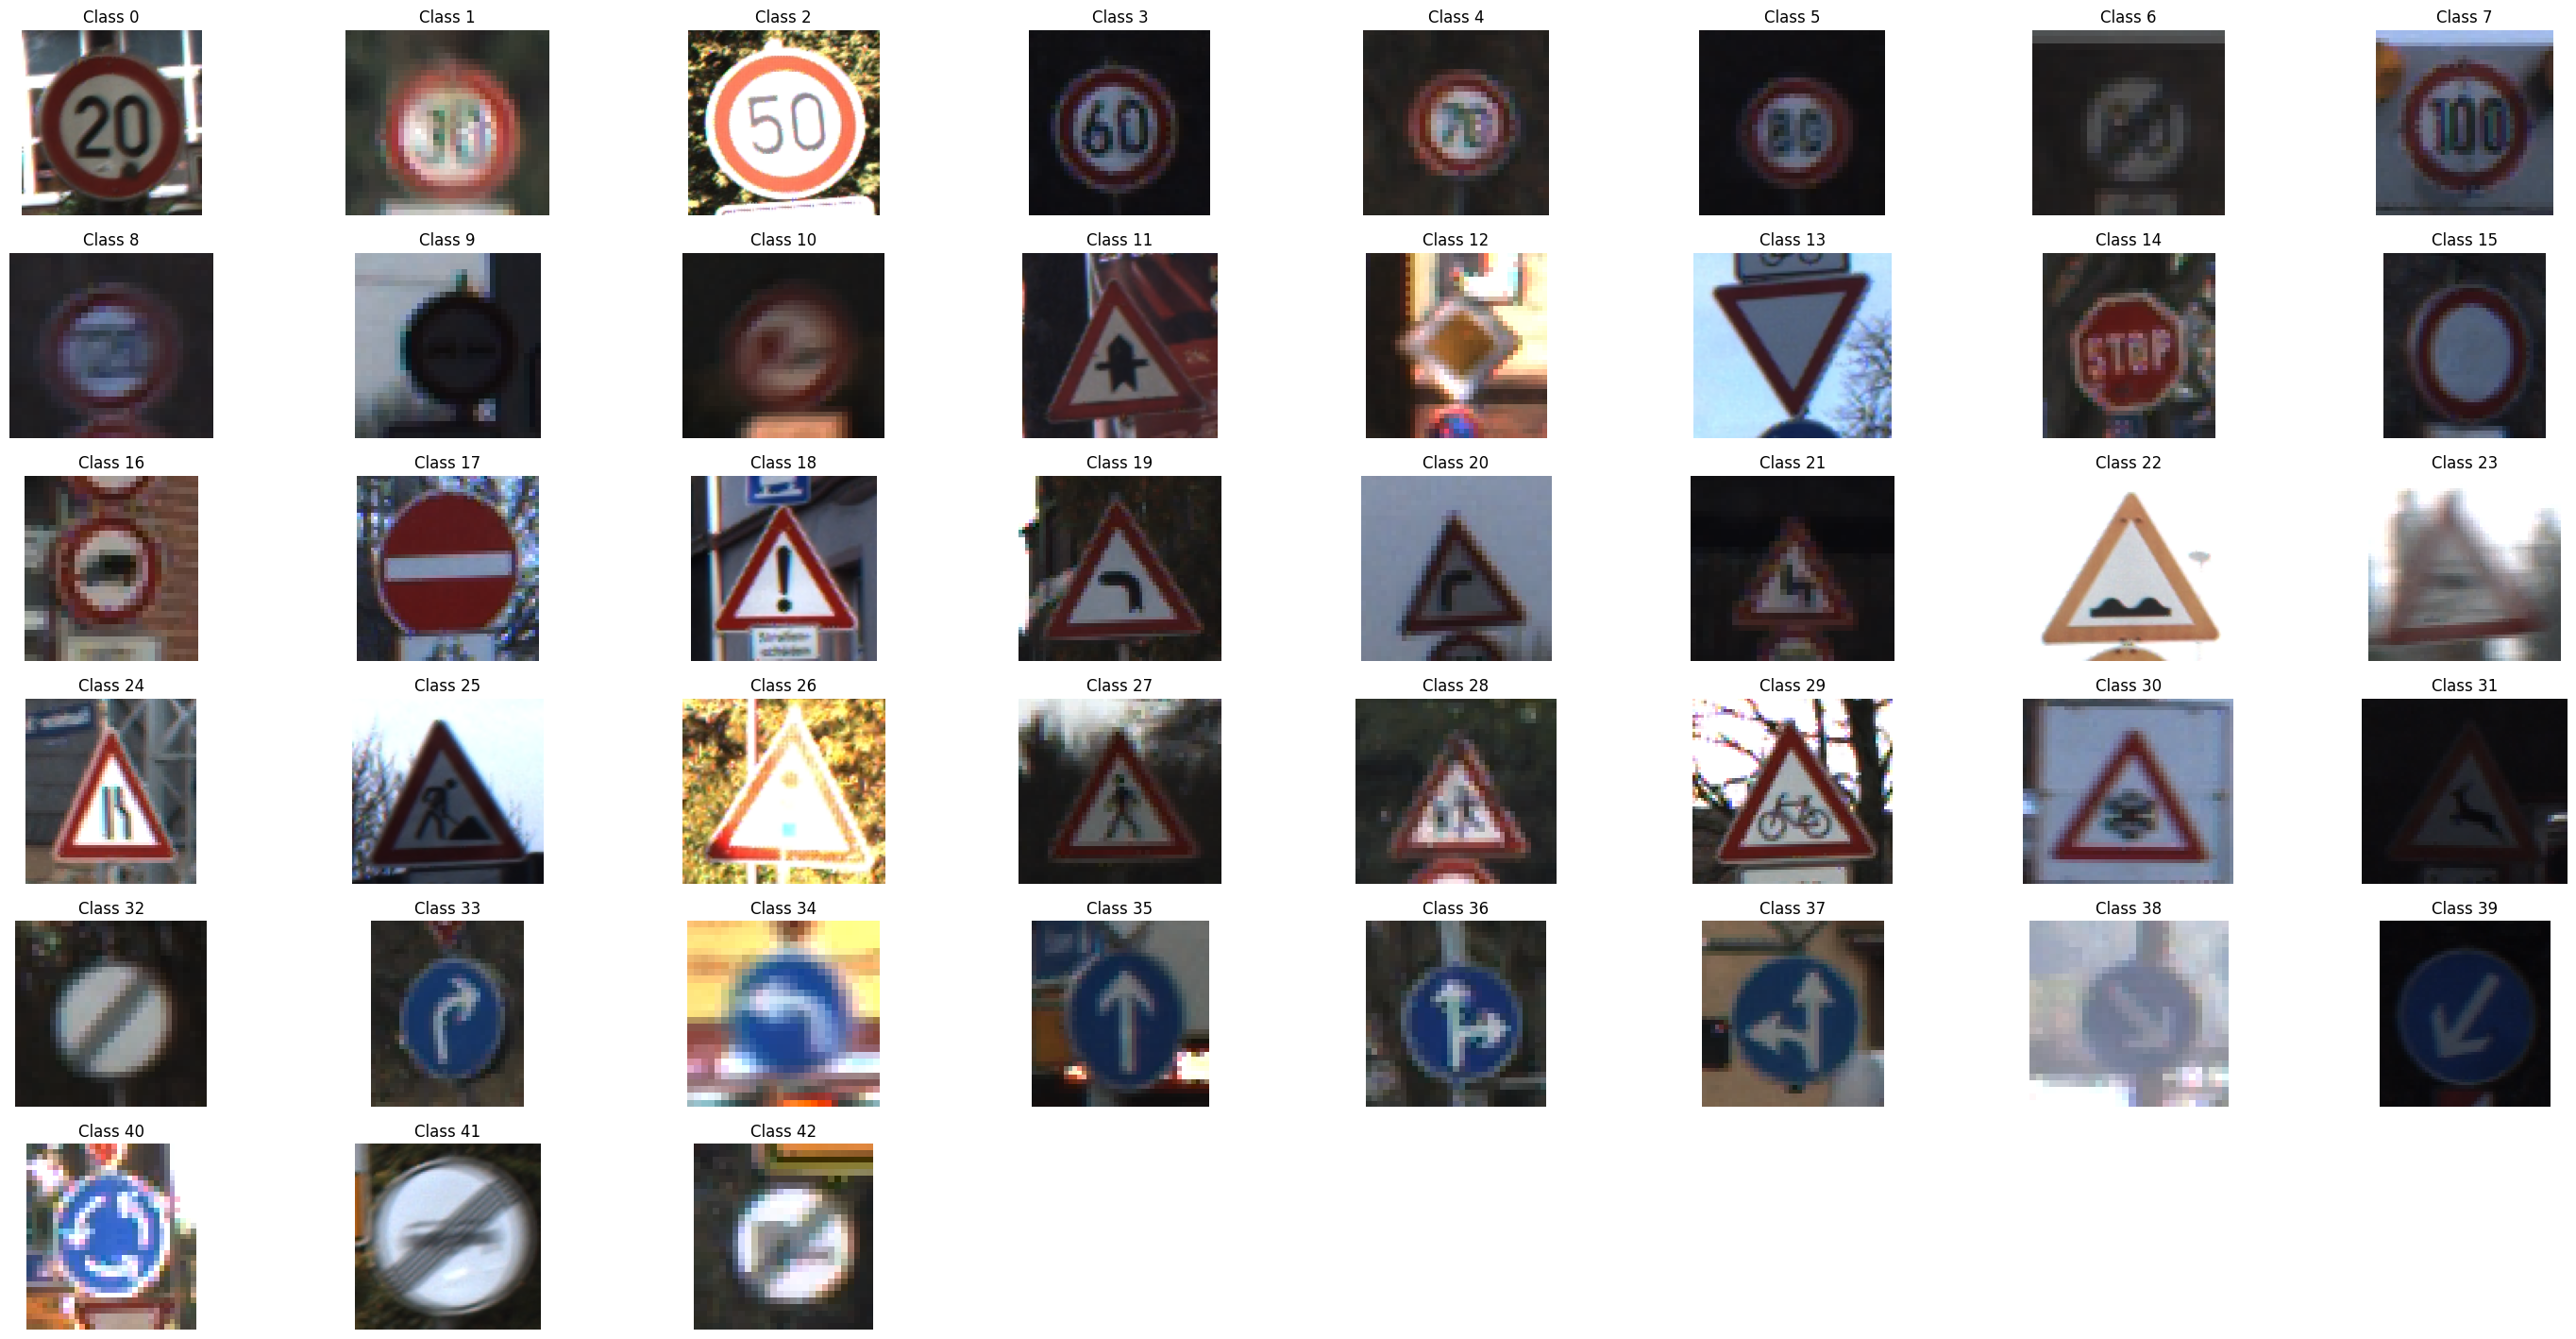

In [8]:
import random

# Sınıf isimlerini unique olarak alıyoruz
class_names = df['ClassId'].unique()

# Görselleştirme işlemi
plt.figure(figsize=(36, 24))

# Her sınıf için rastgele bir görsel seç ve görselleştir
for c in class_names:
    # Belirli sınıfa ait görsellerin indexlerini seçiyoruz
    indices = df[df['ClassId'] == c].index
    # Bu sınıftan rastgele bir görsel seçiyoruz
    i = random.choice(indices)
    # Alt grafik oluşturma
    plt.subplot(8, 8, c + 1)
    plt.axis("off")
    plt.title(f"Class {c}")
    # Görseli yükleyip gösterme
    img_path = os.path.join("/kaggle/input/gtsrb-german-traffic-sign", df.loc[i, 'Path'])
    img = Image.open(img_path)
    plt.imshow(img)

plt.show()

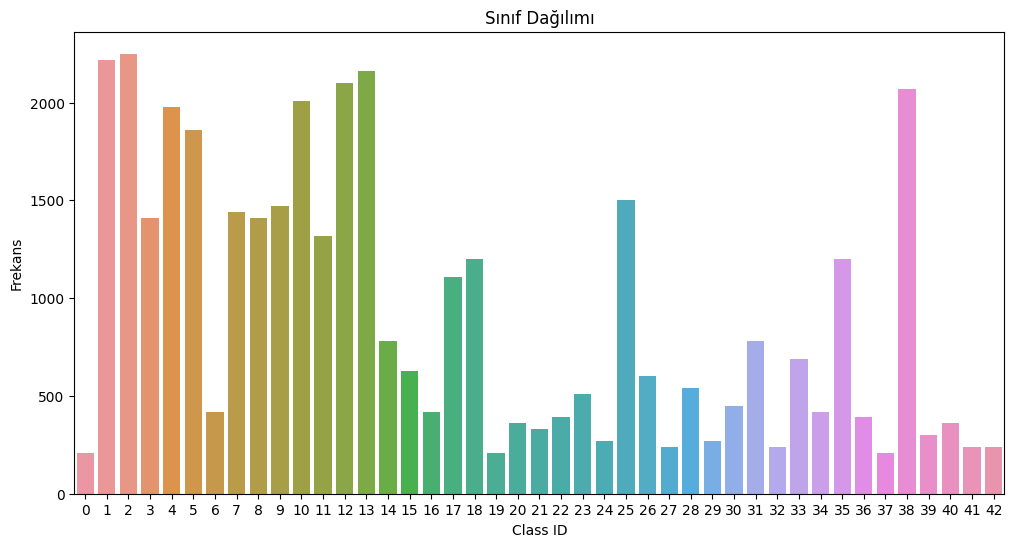

In [9]:
# Sınıf dağılımını kontrol etme
class_distribution = df['ClassId'].value_counts()

# Çubuk grafikte görselleştirme
plt.figure(figsize=(12, 6))
sns.barplot(x=class_distribution.index, y=class_distribution.values)
plt.title("Sınıf Dağılımı")
plt.xlabel("Class ID")
plt.ylabel("Frekans")
plt.show()

1. Sınıf Dengesizliği:

Bazı sınıflar (örneğin, Class ID 38) oldukça yüksek bir örnek sayısına sahipken, diğer sınıflar (örneğin, Class ID 0) çok daha düşük bir örnek sayısına sahip.
Bu tür dengesizlikler, modelin sık görülen sınıflara öncelik verip nadir sınıfları öğrenmekte zorlanmasına neden olabilir.

2. Eğitim Verisi Çeşitliliği:

Daha fazla veriye sahip sınıflar (ör. Class ID 13, 38) modelin bu sınıfları öğrenmesini kolaylaştırabilir. Ancak, bu sınıfların ağırlığı artacağı için dengesiz sonuçlara yol açabilir.

3. Nadir Sınıflar:

Özellikle düşük örnek sayısına sahip sınıflar (ör. Class ID 0, 19, 22) için veri artırma (data augmentation) yöntemleri kullanılabilir. Bu yöntemlerle bu sınıfların örnek sayısı artırılabilir.

In [6]:
# Görselleri okuma ve yeniden boyutlandırma (ör. 43x43 boyutunda)
def load_and_resize_images(paths, base_path, size=(43, 43)):
    images = []
    for path in paths:
        img_path = os.path.join(base_path, path)
        with Image.open(img_path) as img:
            img = img.resize(size)
            images.append(np.array(img).flatten())  # Görselleri tek bir vektöre dönüştürüyoruz
    return np.array(images)

# Görselleri yükleme
X_train_images = load_and_resize_images(X_train, base_path, size=(43, 43))

In [8]:
# Standartlaştırma (StandartScaler)
scaler_standard = StandardScaler()
X_scaled_standard = scaler_standard.fit_transform(X_train_images)

# MinMaxScaler ile ölçekleme
scaler_minmax = MinMaxScaler()
X_scaled_minmax = scaler_minmax.fit_transform(X_train_images)

# İlk birkaç veri örneğini kontrol edelim
print("Standartlaştırılmış (StandardScaler) Veriler:")
print(X_scaled_standard[:5])
print("\nMinMaxScaler ile Ölçeklenmiş Veriler:")
print(X_scaled_minmax[:5])

Standartlaştırılmış (StandardScaler) Veriler:
[[-0.66871523 -0.61853345 -0.64333218 ...  0.41091828  0.60746854
   0.51798179]
 [-0.95569917 -0.95679592 -0.92536361 ... -0.88179489 -0.87464929
  -0.81805947]
 [-0.59044688 -0.63154354 -0.75870867 ... -0.12771221 -0.31300464
  -0.62944188]
 [-0.89047554 -0.87873535 -0.7843479  ... -0.7432899  -0.76544061
  -0.66087814]
 [-0.04256846 -0.09812964 -0.68179101 ...  1.13422207  1.10670822
   0.06215595]]

MinMaxScaler ile Ölçeklenmiş Veriler:
[[0.132      0.14342629 0.14509804 ... 0.37647059 0.4063745  0.38823529]
 [0.044      0.03984064 0.05882353 ... 0.04705882 0.02788845 0.05490196]
 [0.156      0.13944223 0.10980392 ... 0.23921569 0.17131474 0.10196078]
 [0.064      0.06374502 0.10196078 ... 0.08235294 0.05577689 0.09411765]
 [0.324      0.30278884 0.13333333 ... 0.56078431 0.53386454 0.2745098 ]]


In [9]:
# Test Görselleri yükleme
X_test_images = load_and_resize_images(X_test, base_path, size=(43, 43))

# Test verisini her modelin ölçeklendirmesine göre hazırlama
X_test_standard = scaler_standard.transform(X_test_images)
X_test_minmax = scaler_minmax.transform(X_test_images)

In [13]:
# MLP Modeli Oluşturma
mlp_model = MLPClassifier(hidden_layer_sizes=(100,), activation='relu', 
                          learning_rate='adaptive', max_iter=500, random_state=42)

# MLP Modeli Eğitimi
mlp_model.fit(X_scaled_standard, y_train)

# Tahminler
y_pred = mlp_model.predict(X_test_standard)

# Performans Değerlendirmesi
print("MLP Modeli Sonuçları:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

MLP Modeli Sonuçları:
Accuracy: 0.9602142310635042

Classification Report:

              precision    recall  f1-score   support

           0       0.98      0.98      0.98        44
           1       0.96      0.96      0.96       474
           2       0.98      0.95      0.96       452
           3       0.97      0.90      0.93       295
           4       0.97      0.96      0.96       420
           5       0.82      0.95      0.88       332
           6       0.96      0.96      0.96        82
           7       0.92      0.91      0.91       276
           8       0.98      0.90      0.94       283
           9       0.99      0.95      0.97       304
          10       0.96      0.99      0.98       349
          11       0.95      0.99      0.97       242
          12       1.00      1.00      1.00       454
          13       0.99      0.99      0.99       441
          14       0.97      1.00      0.99       167
          15       0.94      0.98      0.96       127
     

Model, %96.02 doğruluk oranı ile oldukça başarılı bir performans sergilemiştir. Macro ve weighted ortalama precision, recall ve F1-score değerlerinin %96 civarında olması, modelin sınıflar arasında dengeli bir sonuç elde ettiğini göstermektedir. Özellikle sınıf 12, 16, 35, 37 ve 39, precision ve recall açısından mükemmel sonuçlar almış, F1-score değerleri 1.00 olmuştur. Bu, modelin bu sınıfları tamamen doğru sınıflandırdığını gösterir.

Bununla birlikte, sınıf 19 ve 29 gibi sınıflarda performans nispeten düşüktür. Örneğin, sınıf 19 için precision 0.63, recall 0.88 iken, sınıf 29’un recall değeri düşüktür. Bu, modelin bu sınıflarda diğer sınıflarla karışıklık yaşadığını göstermektedir. Genel olarak, model çoğu sınıfta güçlü bir performans sunmaktadır.

In [14]:
# Yeni MLP modeli farklı parametrelerle
mlp_model_updated = MLPClassifier(hidden_layer_sizes=(200, 100), activation='tanh', 
                                  learning_rate='constant', learning_rate_init=0.001, 
                                  max_iter=500, random_state=42)

# Model eğitimi
mlp_model_updated.fit(X_scaled_standard, y_train)

# Eğitim seti üzerinde tahminler
y_pred_updated = mlp_model_updated.predict(X_test_standard)

# Performans değerlendirmesi
print("Yeni MLP Modeli Sonuçları:")
print("Accuracy:", accuracy_score(y_test, y_pred_updated))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_updated))


Yeni MLP Modeli Sonuçları:
Accuracy: 0.9149451670492221

Classification Report:

              precision    recall  f1-score   support

           0       0.91      0.93      0.92        44
           1       0.92      0.91      0.91       474
           2       0.90      0.89      0.90       452
           3       0.92      0.83      0.87       295
           4       0.89      0.94      0.91       420
           5       0.84      0.80      0.82       332
           6       0.85      1.00      0.92        82
           7       0.70      0.94      0.80       276
           8       0.90      0.82      0.86       283
           9       0.96      0.93      0.95       304
          10       0.94      0.95      0.95       349
          11       0.93      0.93      0.93       242
          12       0.98      0.98      0.98       454
          13       0.99      0.96      0.97       441
          14       0.96      0.98      0.97       167
          15       0.94      0.88      0.91       127


Bu yeni MLP modeli, %91.49 doğruluk oranı ile başarılı bir performans sergilemektedir. Makro ortalama precision, recall ve F1-score değerlerinin %90-91 arasında olması, modelin genel olarak dengeli bir sonuç elde ettiğini göstermektedir. Sınıf 12, 13, 35 ve 37 gibi sınıflarda F1-score değerleri %95-98 arasında değişerek oldukça yüksek performans sağlanırken, sınıf 20 ve 29 gibi bazı sınıflarda performans daha düşüktür. Özellikle sınıf 20'nin precision değeri %76, recall ise %67 seviyesinde kalmış, bu da modelin bazı örneklerde hata yaptığını göstermektedir. Genel olarak, model birçok sınıfta %90 üzeri F1-score ile güçlü bir performans sunmaktadır. Ancak düşük performanslı sınıflar için veri artırımı veya model optimizasyonu gibi iyileştirmeler yapılarak sonuçlar daha da geliştirilebilir.

In [15]:
# Yeni MLP modeli
mlp_model_tuned = MLPClassifier(hidden_layer_sizes=(150, 50), activation='relu', 
                                learning_rate='adaptive', max_iter=1000, random_state=42)

# Model eğitimi
mlp_model_tuned.fit(X_scaled_standard, y_train)

# Tahminler
y_pred_tuned = mlp_model_tuned.predict(X_test_standard)

# Performans değerlendirmesi
print("Tuned MLP Modeli Sonuçları:")
print("Accuracy:", accuracy_score(y_test, y_pred_tuned))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_tuned))


Tuned MLP Modeli Sonuçları:
Accuracy: 0.951542973731191

Classification Report:

              precision    recall  f1-score   support

           0       1.00      0.95      0.98        44
           1       0.97      0.92      0.95       474
           2       0.95      0.93      0.94       452
           3       0.94      0.82      0.87       295
           4       0.95      0.96      0.95       420
           5       0.87      0.90      0.88       332
           6       0.99      1.00      0.99        82
           7       0.81      0.95      0.87       276
           8       0.91      0.97      0.94       283
           9       0.99      0.94      0.96       304
          10       0.97      0.99      0.98       349
          11       0.93      0.97      0.95       242
          12       1.00      0.99      1.00       454
          13       0.99      0.98      0.98       441
          14       1.00      1.00      1.00       167
          15       0.92      0.96      0.94       127


Bu Tuned MLP modeli, %95.15 doğruluk oranı ile oldukça başarılı bir performans göstermiştir. Model, özellikle sınıf 12, 14, 35 ve 37 gibi sınıflarda mükemmel sonuçlar elde etmiş ve bu sınıfları tümüyle doğru bir şekilde sınıflandırmıştır. Precision, recall ve F1-score değerlerinin genel olarak yüksek olması, modelin sınıflar arasında dengeli bir performans sergilediğini kanıtlamaktadır. Bununla birlikte, sınıf 20, 21 ve 23 gibi bazı sınıflarda performans diğerlerine göre bir miktar düşüktür, ancak F1-score değerleri yine de %87’nin üzerindedir. Genel olarak, model üretim için güçlü bir adaydır ve düşük performans gösteren sınıflar için veri artırımı veya sınıf ağırlıklandırma ile daha da iyileştirilebilir.

In [12]:
# MinMax ölçeklenmiş veriyi kullanarak MLP modeli
mlp_model_minmax_tuned = MLPClassifier(
    hidden_layer_sizes=(150,),
    activation='relu',
    learning_rate='adaptive',
    max_iter=1000,
    random_state=42
)

# Modeli eğitme
mlp_model_minmax_tuned.fit(X_scaled_minmax, y_train)

# Eğitim seti üzerinde tahminler
y_pred_minmax_tuned = mlp_model_minmax_tuned.predict(X_test_minmax)

# Performans değerlendirmesi
print("MLP Model (MinMax Ölçeklenmiş Veri) Sonuçları:")
print("Accuracy:", accuracy_score(y_test, y_pred_minmax_tuned))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_minmax_tuned))

MLP Model (MinMax Ölçeklenmiş Veri) Sonuçları:
Accuracy: 0.9576638612598827

Classification Report:

              precision    recall  f1-score   support

           0       1.00      0.95      0.98        44
           1       0.97      0.94      0.95       474
           2       0.97      0.90      0.93       452
           3       0.96      0.90      0.93       295
           4       0.95      0.95      0.95       420
           5       0.85      0.92      0.88       332
           6       0.98      1.00      0.99        82
           7       0.83      0.97      0.90       276
           8       0.96      0.96      0.96       283
           9       0.99      0.97      0.98       304
          10       0.98      0.99      0.98       349
          11       0.96      0.98      0.97       242
          12       0.99      0.99      0.99       454
          13       1.00      0.96      0.98       441
          14       0.97      1.00      0.99       167
          15       0.95      0.99 

Model, %95.77 doğruluk oranı ile başarılı bir performans göstermiştir. Sınıf 6, 12, 14, 35 ve 37 gibi sınıflarda F1-score 1.00 ile mükemmel sonuçlar elde edilirken, genel precision, recall ve F1-score değerleri %95-96 arasında dengeli bir performansı işaret etmektedir.

Bununla birlikte, sınıf 20 ve 29 gibi bazı sınıflarda performans diğerlerine göre daha düşüktür (F1-score: %87 ve %85). Genel olarak, model çoğu sınıfta güçlü sonuçlar verirken düşük performanslı sınıflar için veri artırımı veya optimizasyon yapılabilir.


Accuracy: Genel olarak tüm sınıflar için doğru tahmin edilen örneklerin oranıdır. En yüksek doğruluğa sahip model genellikle genel performans açısından daha iyidir. MLP Model (MinMaxScaler), %95.77 doğruluk oranı ile diğer modellerden daha iyi performans göstermiştir.

Macro Avg Precision (Makro Ortalama Hassasiyet): Tüm sınıflar için precision değerlerinin ortalamasıdır. Modelin yanlış pozitif oranını minimize etme başarısını gösterir. MLP Model (MinMaxScaler), %96 hassasiyet ile en iyi sonucu almıştır, bu da modelin sınıfları doğru sınıflandırmada daha az hata yaptığını gösterir.

Macro Avg Recall (Makro Ortalama Duyarlılık): Tüm sınıflar için recall değerlerinin ortalamasıdır. Modelin gerçek pozitifleri bulma oranını gösterir. MLP Model (MinMaxScaler), %95 duyarlılık ile diğer modellere göre daha dengeli bir performans sergilemiştir.

Macro Avg F1-Score: Precision ve Recall'ün dengeli bir ölçüsüdür. F1-Score, sınıflar arasındaki dengenin ne kadar iyi olduğunu ölçer. MLP Model (MinMaxScaler), %95 F1-Score ile sınıflar arası dengeyi en iyi şekilde sağlamıştır.

In [14]:
# Özel RBF Katmanı
class RBFLayer(Dense):
    def __init__(self, units, gamma=None, **kwargs):
        super().__init__(units, **kwargs)
        self.gamma = K.constant(gamma or 1.0)

    def build(self, input_shape):
        self.centers = self.add_weight(name='centers',
                                       shape=(self.units, input_shape[-1]),
                                       initializer='uniform',
                                       trainable=True)
        self.built = True

    def call(self, inputs):
        diff = K.expand_dims(inputs, axis=1) - self.centers
        return K.exp(-self.gamma * K.sum(diff**2, axis=-1))

In [ ]:
# RBF Ağı
def create_rbf_model(input_dim, num_classes, gamma=0.1):
    model = Sequential([
        Input(shape=(input_dim,)),
        RBFLayer(units=50, gamma=gamma),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
# MinMaxScaler ile RBF Modeli Oluşturma 
input_dim_minmax = X_scaled_minmax.shape[1]
num_classes = len(np.unique(y_train))
rbf_model_minmax = create_rbf_model(input_dim_minmax, num_classes, gamma=0.1)

# Model Eğitimi
rbf_model_minmax.fit(X_scaled_minmax, y_train, epochs=10, batch_size=32)

# Test Seti Üzerinde Değerlendirme
y_pred_rbf_minmax = np.argmax(rbf_model_minmax.predict(X_test_minmax), axis=-1)

# RBF Modeli Performans değerlendirmesi
print("Accuracy:", accuracy_score(y_test, y_pred_rbf_minmax))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_rbf_minmax))

In [ ]:
# RBF Modeli Oluşturma
input_dim_minmax = X_scaled_minmax.shape[1]
rbf_model_minmax = create_rbf_model(input_dim_minmax, num_classes, gamma=0.1)

# Model Eğitimi
rbf_model_minmax.fit(X_scaled_minmax, y_train, epochs=10, batch_size=32)

# Test Seti Üzerinde Değerlendirme
y_pred_rbf_minmax = np.argmax(rbf_model_minmax.predict(X_scaled_minmax), axis=-1)

# RBF Modeli Performans değerlendirmesi
print("Accuracy:", accuracy_score(y_test, y_pred_rbf_minmax))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_rbf_minmax))

In [15]:
# RBF Modeli Oluşturma
input_dim_minmax = X_scaled_minmax.shape[1]
num_classes = len(np.unique(y_train))
rbf_model_minmax = create_rbf_model(input_dim_minmax, num_classes, gamma=0.1)

# Model Eğitimi
rbf_model_minmax.fit(X_scaled_minmax, y_train, epochs=10, batch_size=32)

# Test Seti Üzerinde Değerlendirme
y_pred_rbf_minmax = np.argmax(rbf_model_minmax.predict(X_scaled_minmax), axis=-1)

# RBF Modeli Performans değerlendirmesi
print("Accuracy:", accuracy_score(y_test, y_pred_rbf_minmax))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_rbf_minmax))

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png
...,...,...,...,...,...,...,...,...
39204,52,56,5,6,47,51,42,Train/42/00042_00007_00025.png
39205,56,58,5,5,51,53,42,Train/42/00042_00007_00026.png
39206,58,62,5,6,53,57,42,Train/42/00042_00007_00027.png
39207,63,69,5,7,58,63,42,Train/42/00042_00007_00028.png


In [13]:
# RBF Modeli Oluşturma
input_dim = X_scaled_standard.shape[1]
num_classes = len(np.unique(y_train))
rbf_model = create_rbf_model(input_dim, num_classes, gamma=0.1)

# Model Eğitimi
rbf_model.fit(X_scaled_standard, y_train, epochs=10, batch_size=32)

# Test Seti Üzerinde Değerlendirme
y_pred_rbf = np.argmax(rbf_model.predict(X_test_standard), axis=-1)

# RBF Modeli Performans değerlendirmesi
print("Accuracy:", accuracy_score(y_test, y_pred_rbf))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_rbf))

Epoch 1/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 71s 72ms/step - accuracy: 0.0543 - loss: 3.6870
Epoch 2/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 71s 72ms/step - accuracy: 0.0582 - loss: 3.5312
Epoch 3/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 71s 72ms/step - accuracy: 0.0583 - loss: 3.4890
Epoch 4/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 71s 72ms/step - accuracy: 0.0577 - loss: 3.4870
Epoch 5/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 83s 73ms/step - accuracy: 0.0575 - loss: 3.4831
Epoch 6/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 71s 72ms/step - accuracy: 0.0578 - loss: 3.4855
Epoch 7/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 71s 72ms/step - accuracy: 0.0582 - loss: 3.4888
Epoch 8/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 72s 73ms/step - accuracy: 0.0583 - loss: 3.4819
Epoch 9/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 72s 73ms/step - accuracy: 0.0545 - loss: 3.4851
Epoch 10/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 73s 74ms/step - accuracy: 0.0582 - loss: 3.4866
246/246 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step
Accuracy: 0.057638357561846466

Classification Report:

              precisi

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Bu sonuçlar, RBF modelinin mevcut konfigürasyonunda başarısız olduğunu açıkça göstermektedir. %5.76 doğruluk oranı, modelin sınıfların büyük çoğunluğunu yanlış sınıflandırdığını ve yalnızca tesadüfen birkaç doğru tahmin yaptığını göstermektedir. Ayrıca, tüm sınıflar için precision, recall ve F1-score değerlerinin sıfıra yakın olması, modelin herhangi bir sınıfta anlamlı bir şekilde çalışamadığını doğrulamaktadır.

In [17]:
# RBF Modeli Oluşturma
input_dim_minmax = X_scaled_minmax.shape[1]
num_classes = len(np.unique(y_train))
rbf_model_minmax = create_rbf_model(input_dim_minmax, num_classes, gamma=0.1)

# Model Eğitimi
rbf_model_minmax.fit(X_scaled_minmax, y_train, epochs=10, batch_size=32)

# Test Seti Üzerinde Değerlendirme
y_pred_rbf_minmax = np.argmax(rbf_model_minmax.predict(X_test_minmax), axis=-1)

# RBF Modeli Performans değerlendirmesi
print("Accuracy:", accuracy_score(y_test, y_pred_rbf_minmax))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_rbf_minmax))

Epoch 1/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 71s 72ms/step - accuracy: 0.0708 - loss: 3.6386
Epoch 2/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 81s 72ms/step - accuracy: 0.0946 - loss: 3.4315
Epoch 3/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 70s 72ms/step - accuracy: 0.1039 - loss: 3.3706
Epoch 4/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 70s 71ms/step - accuracy: 0.1080 - loss: 3.3413
Epoch 5/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 70s 72ms/step - accuracy: 0.1089 - loss: 3.3289
Epoch 6/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 71s 72ms/step - accuracy: 0.1150 - loss: 3.3135
Epoch 7/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 71s 72ms/step - accuracy: 0.1205 - loss: 3.3073
Epoch 8/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 71s 72ms/step - accuracy: 0.1202 - loss: 3.2923
Epoch 9/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 71s 72ms/step - accuracy: 0.1251 - loss: 3.2854
Epoch 10/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 71s 72ms/step - accuracy: 0.1290 - loss: 3.2673
246/246 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step
Accuracy: 0.12841111961234378

Classification Report:

              precisio

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


MinMax scaled RBF modeli, önceki denemeye kıyasla %12.84 doğruluk oranı ile biraz daha iyi performans göstermiştir, ancak genel olarak hâlâ oldukça başarısızdır. Macro avg precision (%14), recall (%6) ve F1-score (%6) değerleri, modelin sınıfların büyük çoğunluğunu doğru bir şekilde sınıflandıramadığını ve ciddi iyileştirmelere ihtiyaç duyduğunu göstermektedir. Ayrıca weighted avg precision (%23) diğer makro değerlere göre biraz daha iyi olsa da bu, sınıf dağılımı dengesizliğinden kaynaklanabilir.

In [10]:
def create_rbf_model_updated(input_dim, num_classes, gamma=0.1):
    model = Sequential([
        Input(shape=(input_dim,)),
        # RBF Katmanı
        RBFLayer(units=100, gamma=gamma),
        # Ek Dense Katmanları
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        # Çıkış Katmanı
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.01), 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

In [17]:
# Geliştirilmiş RBF Modeli Oluşturma
input_dim_minmax = X_scaled_minmax.shape[1]
num_classes = len(np.unique(y_train))
rbf_model_improved = create_rbf_model_updated(input_dim_minmax, num_classes, gamma=0.05)

# Model Eğitimi
rbf_model_improved.fit(X_scaled_minmax, y_train, epochs=10, batch_size=32)

# Test Seti Üzerinde Değerlendirme
y_pred_rbf_improved = np.argmax(rbf_model_improved.predict(X_test_minmax), axis=-1)

# RBF Modeli Performans değerlendirmesi
print("Accuracy:", accuracy_score(y_test, y_pred_rbf_improved))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_rbf_improved))

Epoch 1/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 132s 133ms/step - accuracy: 0.0775 - loss: 3.5480
Epoch 2/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 131s 134ms/step - accuracy: 0.1169 - loss: 3.2094
Epoch 3/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 145s 137ms/step - accuracy: 0.1375 - loss: 3.1203
Epoch 4/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 133s 135ms/step - accuracy: 0.1581 - loss: 3.0404
Epoch 5/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 134s 136ms/step - accuracy: 0.1593 - loss: 3.0356
Epoch 6/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 137s 140ms/step - accuracy: 0.1675 - loss: 2.9937
Epoch 7/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 142s 140ms/step - accuracy: 0.1721 - loss: 2.9752
Epoch 8/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 142s 140ms/step - accuracy: 0.1790 - loss: 2.9415
Epoch 9/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 143s 141ms/step - accuracy: 0.1862 - loss: 2.9166
Epoch 10/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 136s 138ms/step - accuracy: 0.1905 - loss: 2.9128
246/246 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step
Accuracy: 0.1777607753124203

Classification Report:

   

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Bu sonuçlar, modelin hala istenilen performans seviyesine ulaşamadığını göstermektedir. %17.78 doğruluk oranı, modelin sınıfların çoğunu yanlış sınıflandırdığını ve yalnızca birkaç sınıfta minimal bir başarı elde edebildiğini göstermektedir. Macro avg precision (%24), recall (%11) ve F1-score (%10) gibi metrikler de genel performansın düşük olduğunu doğrulamaktadır.

Genel Doğruluk: MLP modelleri (%91.49 - %96.02) açık ara RBF modellerinden (%5.76 - %17.78) daha iyi bir performans göstermiştir.

Makro Ortalama Metriği: MLP modelleri precision, recall ve F1-score'da %90 üzeri değerlere ulaşırken, RBF modelleri %24'ü aşamamıştır. Bu, MLP'nin sınıflar arasında daha dengeli bir performans sergilediğini gösterir.

Eğitim Süreci ve Karmaşıklık: MLP modelleri daha hızlı ve verimli bir şekilde öğrenirken, RBF modelleri hiperparametre değişikliklerine rağmen karmaşık veri setinde etkili bir şekilde öğrenememiştir.

RBF modeli, denenen parametrelerle trafik işaretleri gibi karmaşık ve çok sınıflı bir veri setinde başarısız olmuştur. Buna karşılık, MLP modelleri hem doğruluk hem de sınıflar arasındaki denge açısından daha üstün performans göstermiştir. 

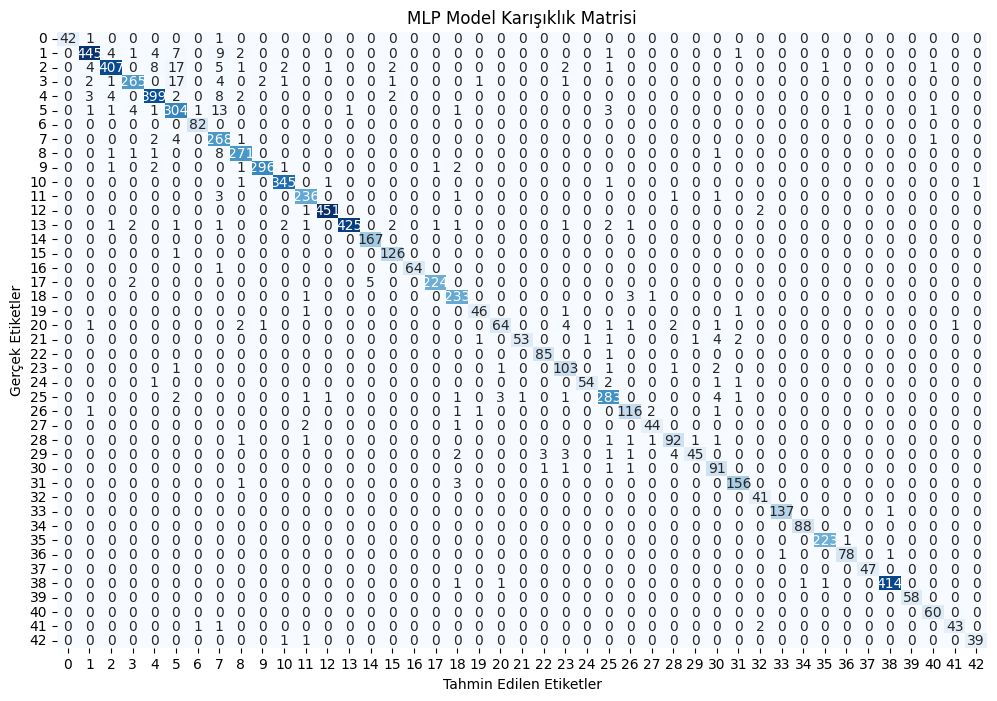

In [21]:
# Karışıklık Matrisi (MLP Modeli)
mlp_confusion = confusion_matrix(y_test, y_pred_minmax_tuned)

# MLP Modeli Karışıklık Matrisi Görselleştirmesi
plt.figure(figsize=(12, 8))
sns.heatmap(mlp_confusion, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("MLP Model Karışıklık Matrisi")
plt.xlabel("Tahmin Edilen Etiketler")
plt.ylabel("Gerçek Etiketler")
plt.show()

Diyagonal Yoğunluğu:

Ana diyagonal boyunca yoğun bir şekilde doğru tahminler yapılmış. Bu, modelin sınıfların büyük bir kısmını doğru sınıflandırdığını gösteriyor.
Örneğin, sınıf 0’dan sınıf 42’ye kadar çoğu sınıf için diyagonal hücrelerde yüksek sayılar mevcut.

Düşük Yanlış Sınıflandırma:

Diyagonal dışındaki hücrelerdeki sayılar oldukça düşük, bu da yanlış sınıflandırmanın az olduğunu gösteriyor.
Özellikle sık karışan sınıflarda bile (örneğin sınıf 6 ve sınıf 8) hatalar minimal düzeyde.

Genel Performans:

MLP modeli, tüm sınıflar arasında tutarlı bir performans sergilemiş ve neredeyse tüm sınıflarda yüksek doğruluk sağlamış. Bu, sınıfların özelliklerini iyi öğrenebildiğini gösteriyor.

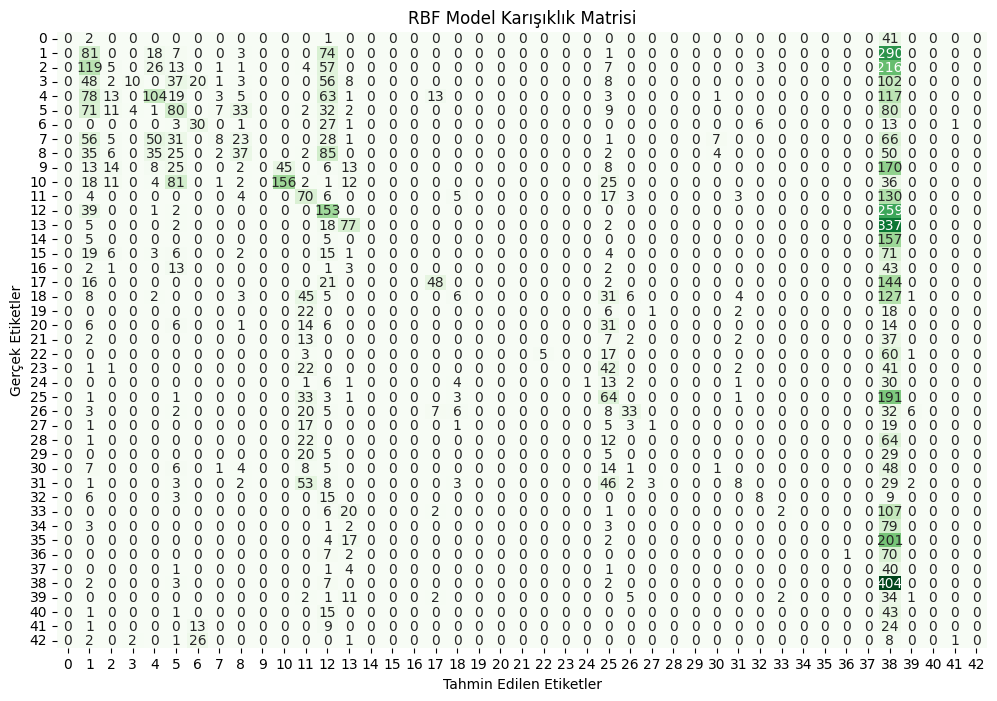

In [18]:
# Karışıklık Matrisi (RBF Modeli)
rbf_confusion = confusion_matrix(y_test, y_pred_rbf_improved)

# RBF Modeli Karışıklık Matrisi Görselleştirmesi
plt.figure(figsize=(12, 8))
sns.heatmap(rbf_confusion, annot=True, fmt="d", cmap="Greens", cbar=False)
plt.title("RBF Model Karışıklık Matrisi")
plt.xlabel("Tahmin Edilen Etiketler")
plt.ylabel("Gerçek Etiketler")
plt.show()

Karışıklık:

Model, belirli sınıfları diğer sınıflarla karıştırma eğiliminde. Örneğin, sınıf 6'nın diğer birçok sınıfla karıştırıldığını gözlemliyoruz.
Bu karışıklık, modelin sınıflar arasındaki farklılıkları iyi öğrenemediğini ve özellik çıkarmada sorun yaşadığını gösteriyor.

Dengesizlik:

Bazı sınıflar (örneğin sınıf 12 ve sınıf 38) nispeten daha iyi tahmin edilirken, birçok sınıfta (örneğin sınıf 15, 40) tahmin performansı sıfıra yakın. Bu, modelin belirli sınıflar üzerinde odaklanmış olabileceğini veya veri setindeki dengesizliğin etkisini gösterebilir.

Model Kısıtlamaları:

RBF modeli, veri setindeki yüksek boyutlu karmaşık dağılımları öğrenmede yetersiz kalmış gibi görünüyor.
Modelin hiperparametrelerinin (örneğin gamma, ünite sayısı) optimize edilmesi ve daha güçlü bir mimariyle desteklenmesi gerekebilir.

### Sonuç

MLP modeli, sınıflar arasında yüksek doğruluk, düşük hata oranı ve genel tutarlılığıyla RBF modeline kıyasla çok daha üstün bir performans göstermiştir. RBF modeli ise doğru sınıflandırmada çok sınırlı başarı sağlayabilmiş ve sınıflar arasında ciddi karışıklık yaşamıştır. Bu durum, RBF'nin karmaşık ve çok sınıflı veri setlerinde yetersiz kalabileceğini, buna karşın MLP'nin bu tür veri setleri için daha uygun olduğunu açıkça göstermektedir.

In [31]:
# GridSearch için hiperparametreler
param_grid = {
    'hidden_layer_sizes': [(100,), (50, 50), (100, 50), (100, 100)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam'],
    'alpha': [0.001, 0.01, 0.1],  # L2 regularization
    'learning_rate': ['adaptive'],
}

# GridSearchCV Tanımı
grid_search = GridSearchCV(
    param_grid=param_grid,
    estimator=MLPClassifier(max_iter=20, random_state=42),
    cv=3,  # 3 katlı çapraz doğrulama
    scoring='accuracy',  # Doğruluk skoruna göre değerlendir
    verbose=2,  # Daha fazla çıktı görmek için
    n_jobs=-1  # Paralel işlem için tüm çekirdekleri kullan
)

# GridSearchCV'yi Eğit
grid_search.fit(X_scaled_minmax, y_train)

# En İyi Parametreler ve Skor
print("En İyi Parametreler:", grid_search.best_params_)
print("En İyi Doğruluk Skoru:", grid_search.best_score_)

# En İyi Model
best_model = grid_search.best_estimator_

Fitting 3 folds for each of 24 candidates, totalling 72 fits


/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py

En İyi Parametreler: {'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_sizes': (100,), 'learning_rate': 'adaptive', 'solver': 'adam'}
En İyi Doğruluk Skoru: 0.9466000222471282


/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam; total time= 1.8min
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate=adaptive, solver=adam; total time= 1.1min
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 100), learning_rate=adaptive, solver=adam; total time= 1.9min
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam; total time= 1.8min
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50), learning_rate=adaptive, solver=adam; total time= 1.1min
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 100), learning_rate=adaptive, solver=adam; total time= 1.9min
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam; total time= 1.8min
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(50, 50), learning_rate=adaptive, solver=adam; total time= 1.1min
[CV] END activati

In [33]:
# MinMax ölçeklenmiş En İyi Parametrelerle MLP Modeli
mlp_model_minmax_best = MLPClassifier(
    hidden_layer_sizes=(100,),  # En iyi parametrelerden
    activation='tanh',          # En iyi aktivasyon fonksiyonu
    learning_rate='adaptive',   # En iyi öğrenme oranı stratejisi
    solver='adam',              # En iyi optimizasyon algoritması
    alpha=0.01,                 # En iyi regularization parametresi
    max_iter=1000,              # Yeterli iterasyon sayısı
    random_state=42             # Tekrarlanabilirlik için
)

# Modeli eğitme
mlp_model_minmax_best.fit(X_scaled_minmax, y_train)

# Eğitim seti üzerinde tahminler
y_pred_minmax_best = mlp_model_minmax_best.predict(X_test_minmax)

# Performans değerlendirmesi
print("MLP Model (MinMax En İyi Parametre) Sonuçları:")
print("Accuracy:", accuracy_score(y_test, y_pred_minmax_best))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_minmax_best))

MLP Model (MinMax En İyi Parametre) Sonuçları:
Accuracy: 0.9445294567712318

Classification Report:

              precision    recall  f1-score   support

           0       1.00      0.75      0.86        44
           1       0.93      0.92      0.93       474
           2       0.93      0.94      0.93       452
           3       0.97      0.87      0.92       295
           4       0.96      0.96      0.96       420
           5       0.84      0.92      0.88       332
           6       1.00      0.96      0.98        82
           7       0.94      0.91      0.93       276
           8       0.91      0.98      0.95       283
           9       0.99      0.97      0.98       304
          10       0.99      0.98      0.98       349
          11       0.98      0.90      0.94       242
          12       1.00      0.97      0.99       454
          13       0.97      0.98      0.98       441
          14       1.00      0.96      0.98       167
          15       0.97      0.91 

Bu model, MinMax ölçeklenmiş veriler ve GridSearch ile optimize edilmiş en iyi parametrelerle eğitilmiş bir MLP modelidir. Modelin doğruluk oranı %94.45 ile oldukça iyi bir performans sergilemektedir. Precision, recall ve F1-score değerleri genel olarak yüksek olup, birçok sınıfta dengeli bir performans sağlamıştır.

Yüksek Performanslı Sınıflar: Model, özellikle 12, 13, 35, 38, 40 ve 42 gibi sınıflarda mükemmel sonuçlar elde etmiştir. Bu sınıflarda F1-score %95 ile %99 arasında değişmektedir ve model bu sınıfları neredeyse tamamen doğru şekilde tahmin edebilmiştir.

Zorlanılan Sınıflar: Sınıf 0, 20, 27 ve 29 gibi sınıflarda performans diğerlerine kıyasla biraz daha düşüktür. Örneğin, sınıf 20’nin F1-score değeri %82 iken, sınıf 29 için bu değer %78 olarak gerçekleşmiştir. Bu, modelin bu sınıflarda yanlış pozitif ve negatif oranlarının diğer sınıflara göre daha yüksek olduğunu göstermektedir.

Genel Performans: Weighted average F1-score %94 civarındadır. Bu, sınıf dengesizliği olmasına rağmen modelin genel başarısını koruduğunu gösterir.

RBF modeli ise %18 doğruluk oranı ile oldukça düşük bir performans göstermişti. Buna karşın, MLP modelinin %94.45 doğruluk oranı, MLP'nin RBF'e kıyasla açık bir üstünlük sağladığını ortaya koymaktadır.

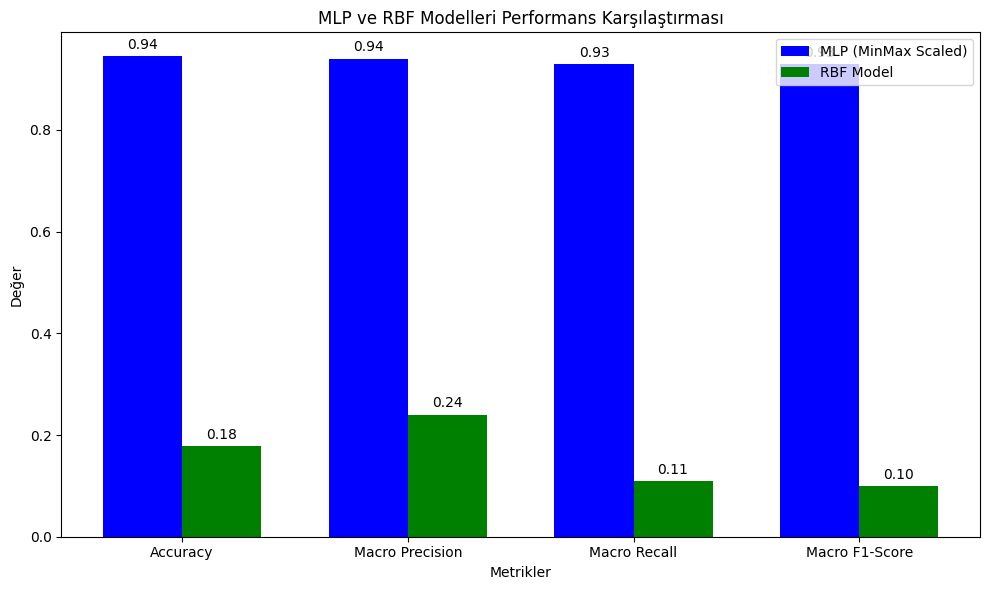

In [34]:
# Performans metrikleri
data = {
    "Model": ["MLP (MinMax Scaled)", "RBF Model"],
    "Accuracy": [0.9445, 0.1777],
    "Macro Precision": [0.94, 0.24],
    "Macro Recall": [0.93, 0.11],
    "Macro F1-Score": [0.93, 0.10]
}

performance_df = pd.DataFrame(data)

# Performans metriklerini bar grafiği olarak çizelim
metrics = ["Accuracy", "Macro Precision", "Macro Recall", "Macro F1-Score"]
x = np.arange(len(metrics))

width = 0.35  # Bar genişliği

fig, ax = plt.subplots(figsize=(10, 6))

# Çubukları ekleyelim
bar1 = ax.bar(x - width/2, performance_df.iloc[0, 1:], width, label="MLP (MinMax Scaled)", color="blue")
bar2 = ax.bar(x + width/2, performance_df.iloc[1, 1:], width, label="RBF Model", color="green")

# Grafik ayarları
ax.set_xlabel("Metrikler")
ax.set_ylabel("Değer")
ax.set_title("MLP ve RBF Modelleri Performans Karşılaştırması")
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Değerleri çubukların üzerine ekleyelim
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f"{height:.2f}",
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 birim yukarı
                    textcoords="offset points",
                    ha="center", va="bottom")

add_labels(bar1)
add_labels(bar2)

plt.tight_layout()
plt.show()


In [35]:
import joblib

# Modeli kaydet
joblib.dump(mlp_model_minmax_best, 'mlp_model_minmax_best.pkl')

print("Model başarıyla 'mlp_model_minmax_best.pkl' dosyasına kaydedildi.")

Model başarıyla 'mlp_model_minmax_best.pkl' dosyasına kaydedildi.
